# Lotka Volterra UPINN

In [ ]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [25]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 5 # Number of data points

time_int = [0, 20]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LVData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points)

td = data.td
Xd = data.Xd

In [3]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [4]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [5]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']
        self.param_log = dict()

    def forward(self, z, U):

        sp = torch.nn.Softplus()

        if type(self.alpha) == torch.nn.parameter.Parameter: self.param_log.setdefault('alpha', []).append(sp(self.alpha).item())
        if type(self.beta) == torch.nn.parameter.Parameter: self.param_log.setdefault('beta', []).append(sp(self.beta).item()) 
        if type(self.delta) == torch.nn.parameter.Parameter: self.param_log.setdefault('delta', []).append(sp(self.delta).item())
        if type(self.gamma) == torch.nn.parameter.Parameter: self.param_log.setdefault('gamma', []).append(sp(self.gamma).item())

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - sp(self.alpha)*U[:, 0] + sp(self.beta)*U[:, 0]*U[:, 1],
            dUdt[:, 1] + sp(self.delta)*U[:, 1] - sp(self.gamma)*U[:, 0]*U[:, 1]
        ], dim=-1)


params = dict(
    alpha=torch.nn.Parameter(torch.tensor(0.0)),
    beta=torch.nn.Parameter(torch.tensor(0.0)),
    delta=torch.nn.Parameter(torch.tensor(0.0)),
    gamma=torch.nn.Parameter(torch.tensor(0.0))
)

N = SparseLV(params)

### Problem specific UPINN functions

In [6]:
class LV_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            
            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save+'pdf', format='pdf', bbox_inches='tight')

            plt.show()

### Setup UPINN

In [7]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)

In [8]:
upinn = LV_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [ ]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
upinn.optimizer = adamw

for i in range(50):
    upinn.train_loop(epochs=1000)
    print(N.param_log['alpha'][-1], N.param_log['beta'][-1], N.param_log['delta'][-1], N.param_log['gamma'][-1])

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:26<00:00, 38.07 epoch/s, loss=1.51e-05, bc_loss=1.45e-09, data_loss=4.92e-08, pde_loss=1.50e-05]

0.6641872525215149 1.3301678895950317 1.001417636871338 1.0009208917617798


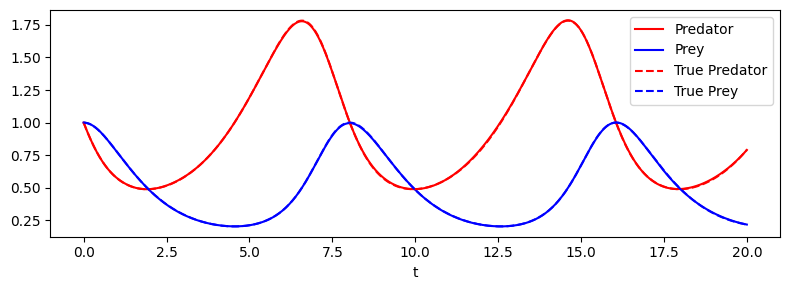

In [30]:
plt.figure( figsize=(8, 3) )

u_pred = upinn.u(data.t_full)

plt.plot(data.t_full, u_pred[:, 0].detach().numpy(), 'r', label='Predator')
plt.plot(data.t_full, u_pred[:, 1].detach().numpy(), 'b', label='Prey')
plt.plot(data.t_full, data.X_full[:, 0].detach().numpy(), 'r--', label='True Predator')
plt.plot(data.t_full, data.X_full[:, 1].detach().numpy(), 'b--', label='True Prey')
plt.xlabel('t')
plt.legend()
plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse.pdf', format='pdf', bbox_inches='tight')
plt.show()

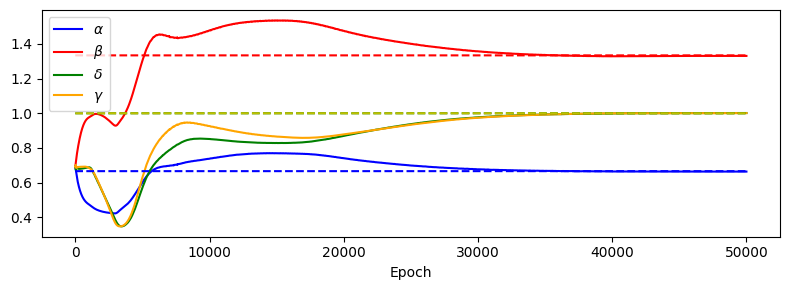

In [31]:
plt.figure( figsize=(8, 3) )

plt.plot(N.param_log['alpha'], label=r'$\alpha$', color='blue')
plt.plot(N.param_log['beta'], label=r'$\beta$', color='red')
plt.plot(N.param_log['delta'], label=r'$\delta$', color='green')
plt.plot(N.param_log['gamma'], label=r'$\gamma$', color='orange')

plt.plot([alpha]*len(N.param_log['alpha']), 'b--')
plt.plot([beta]*len(N.param_log['beta']), 'r--')
plt.plot([delta]*len(N.param_log['delta']), 'g--')
plt.plot([gamma]*len(N.param_log['gamma']), 'y--')

plt.legend()
plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse-params.pdf', format='pdf', bbox_inches='tight')
plt.show()